<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Regularization in Linear Regression
Estimated time needed: **30** minutes
    

## Objectives


After completing this lab you will be able to:

* Implement, evaluate, and compare the performance of three regularization techniques for linear regression
* Analyze the effect of simple linear regularization when modelling on noisy data with and without outliers
* Use Lasso regularization to reduce the number of features for subsequent multiple linear regression modelling


Before you begin the lab, ensure the availability of all the required libraries by executing the cell below.


In [1]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 189.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 161.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 179.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 182.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 148.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 110.7 MB/s eta 0:00:00


### Import the required libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

### Define a function to display evaluation metrics 
We'll be evaluating several models, so its a good idea to make an evaluation function that includes the common metrics and explaned variances etc.


In [3]:
def regression_results(y_true, y_pred, regr_type):

    # Regression metrics
    ev = explained_variance_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred) 
    mse = mean_squared_error(y_true, y_pred) 
    r2 = r2_score(y_true, y_pred)
    
    print('Evaluation metrics for ' + regr_type + ' Linear Regression')
    print('explained_variance: ',  round(ev,4)) 
    print('r2: ', round(r2,4))
    print('MAE: ', round(mae,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print()


### Generate a simple dataset with one feature
We'll create a simple data set with a linear relationship between the target and a single feature.
We'll add some noise to the target to simulate real data.
We'll also create a data set from this one that has outliers added. 
Then you'll compare the three linear regression model performances on the two datasets, with and without sigiifcant outliers added.


In [4]:
# Generate synthetic data
noise=1
np.random.seed(42)
X = 2 * np.random.rand(1000, 1)
y = 4 + 3 * X + noise*np.random.randn(1000, 1)  # Linear relationship with some noise
y_ideal =  4 + 3 * X
# Specify the portion of the dataset to add outliers (e.g., the last 20%)
y_outlier = pd.Series(y.reshape(-1).copy())

# Identify indices where the feature variable X is greater than a certain threshold
threshold = 1.5  # Example threshold to add outliers for larger feature values
outlier_indices = np.where(X.flatten() > threshold)[0]

# Add outliers at random locations within the specified portion
num_outliers = 5  # Number of outliers to add
selected_indices = np.random.choice(outlier_indices, num_outliers, replace=False)

# Modify the target values at these indices to create outliers (add significant noise)
y_outlier[selected_indices] += np.random.uniform(50, 100, num_outliers)

### Plot the data with outliers and the ideal fit line


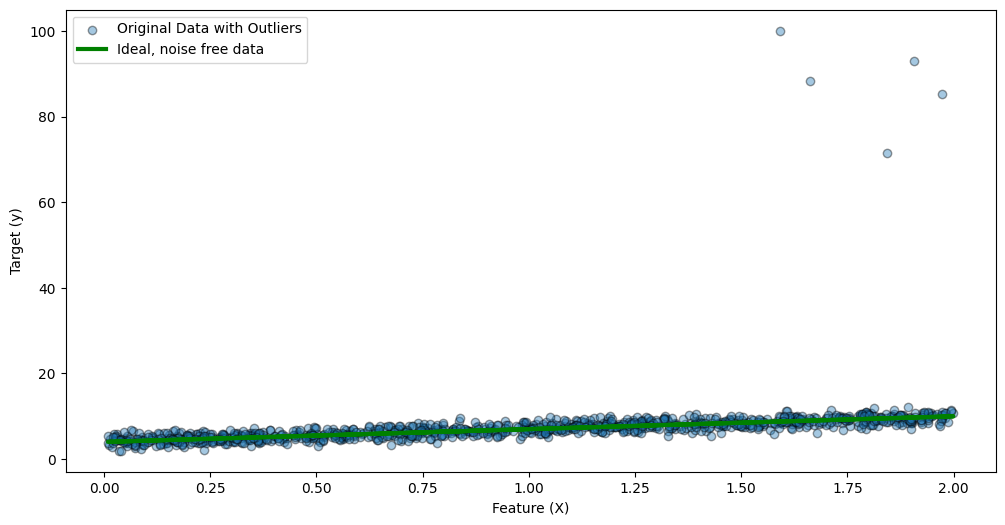

In [5]:
plt.figure(figsize=(12, 6))

# Scatter plot of the original data with outliers
plt.scatter(X, y_outlier, alpha=0.4,ec='k', label='Original Data with Outliers')
plt.plot(X, y_ideal,  linewidth=3, color='g',label='Ideal, noise free data')

plt.xlabel('Feature (X)')
plt.ylabel('Target (y)')
plt.title('')
plt.legend()
plt.show()


### Exercise 1. Plot the data without the outliers and the ideal fit line


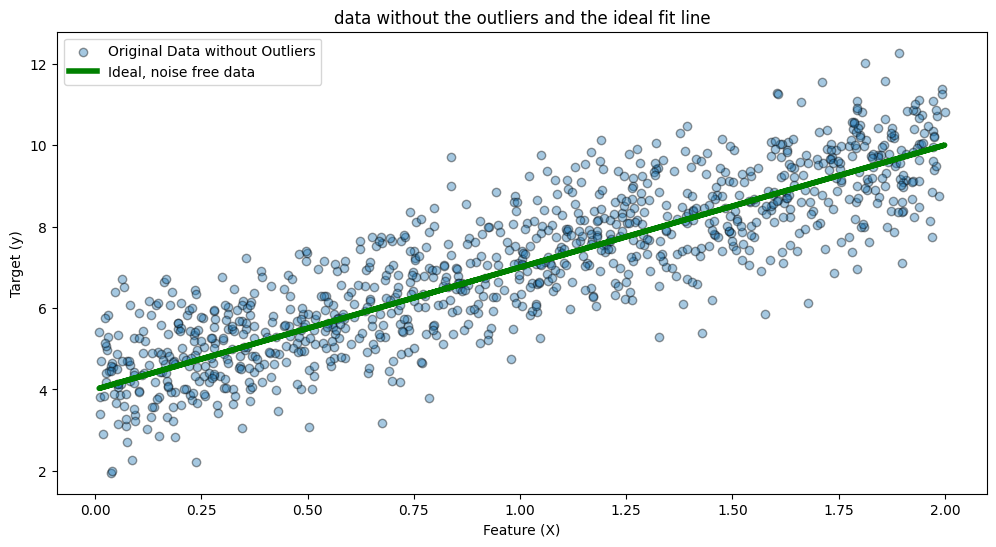

In [6]:
# Enter your code here
plt.figure(figsize=(12, 6))

# Scatter plot of the original data with outliers
plt.scatter(X, y, alpha=0.4,ec='k', label='Original Data without Outliers')
plt.plot(X, y_ideal,  linewidth=4, color='g',label='Ideal, noise free data')

plt.xlabel('Feature (X)')
plt.ylabel('Target (y)')
plt.title('data without the outliers and the ideal fit line')
plt.legend()
plt.show()


<details><summary>Click here for the solution</summary>
    
```python
    
plt.figure(figsize=(12, 6))

# Scatter plot of the original data with outliers
plt.scatter(X, y, alpha=0.4,ec='k', label='Original Data without Outliers')
plt.plot(X, y_ideal,  linewidth=4, color='g',label='Ideal, noise free data')

plt.xlabel('Feature (X)')
plt.ylabel('Target (y)')
plt.title('')
plt.legend()
plt.show()
```


### Fit Ordinary, Ridge, and Lasso regression models and use them to make predicitions on the outlier-included data


In [7]:
# Fit a simple linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y_outlier)
y_outlier_pred_lin = lin_reg.predict(X)

# Fit a ridge regression model (regularization to control large coefficients)
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(X, y_outlier)
y_outlier_pred_ridge = ridge_reg.predict(X)

# Fit a lasso regression model (regularization to control large coefficients)
lasso_reg = Lasso(alpha=.2)
lasso_reg.fit(X, y_outlier)
y_outlier_pred_lasso = lasso_reg.predict(X)

### Print the regression results


In [8]:
regression_results(y, y_outlier_pred_lin, 'Ordinary')
regression_results(y, y_outlier_pred_ridge, 'Ridge')
regression_results(y, y_outlier_pred_lasso, 'Lasso')

Evaluation metrics for Ordinary Linear Regression
explained_variance:  0.6748
r2:  0.6357
MAE:  0.9468
MSE:  1.4164
RMSE:  1.1901

Evaluation metrics for Ridge Linear Regression
explained_variance:  0.6766
r2:  0.6375
MAE:  0.9443
MSE:  1.4094
RMSE:  1.1872

Evaluation metrics for Lasso Linear Regression
explained_variance:  0.7394
r2:  0.7003
MAE:  0.8597
MSE:  1.1651
RMSE:  1.0794



Judging from the low R^2 values, these are poor predictions
### Plot the data and the predictions for comparison
Let's see how well the predictions match expected ideal values.


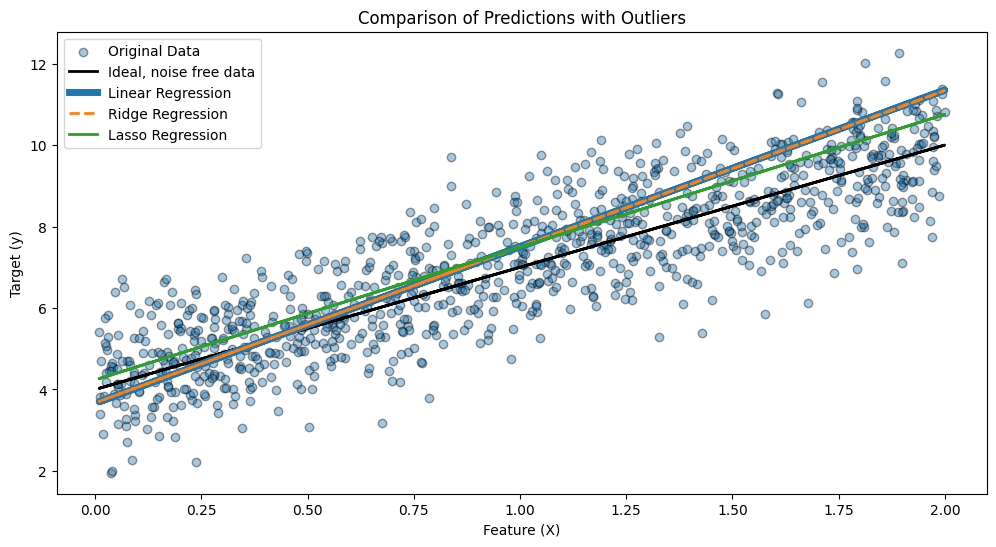

In [9]:
plt.figure(figsize=(12, 6))

# Scatter plot of the original data with outliers
plt.scatter(X, y, alpha=0.4,ec='k', label='Original Data')

# Plot the ideal regression line (noise free data)
plt.plot(X, y_ideal,  linewidth=2, color='k',label='Ideal, noise free data')

# Plot predictions from the simple linear regression model
plt.plot(X, y_outlier_pred_lin,  linewidth=5, label='Linear Regression')

# Plot predictions from the ridge regression model
plt.plot(X, y_outlier_pred_ridge, linestyle='--', linewidth=2, label='Ridge Regression')

# Plot predictions from the lasso regression model
plt.plot(X, y_outlier_pred_lasso,  linewidth=2, label='Lasso Regression')

plt.xlabel('Feature (X)')
plt.ylabel('Target (y)')
plt.title('Comparison of Predictions with Outliers')
plt.legend()
plt.show()

As you can see, ordinary linear and ridge resgression performed similarly, while Lasso outperformed both. 

Although the intercept is off for the Lasso fit line, it's slope is much closer to the ideal than the other fit lines.

All three lines were 'pulled up' by the outliers (not plotted here - compare to the plot above where the outliers are shown), with Lasso dampening that effect.


### Exercise 2. Build the models and the prediction plots from the same data, excluding the outliers


Evaluation metrics for Ordinary Linear Regression
explained_variance:  0.7492
r2:  0.7492
MAE:  0.7873
MSE:  0.975
RMSE:  0.9874

Evaluation metrics for Ridge Linear Regression
explained_variance:  0.7492
r2:  0.7492
MAE:  0.7874
MSE:  0.975
RMSE:  0.9874

Evaluation metrics for Lasso Linear Regression
explained_variance:  0.7191
r2:  0.7191
MAE:  0.8408
MSE:  1.0923
RMSE:  1.0451



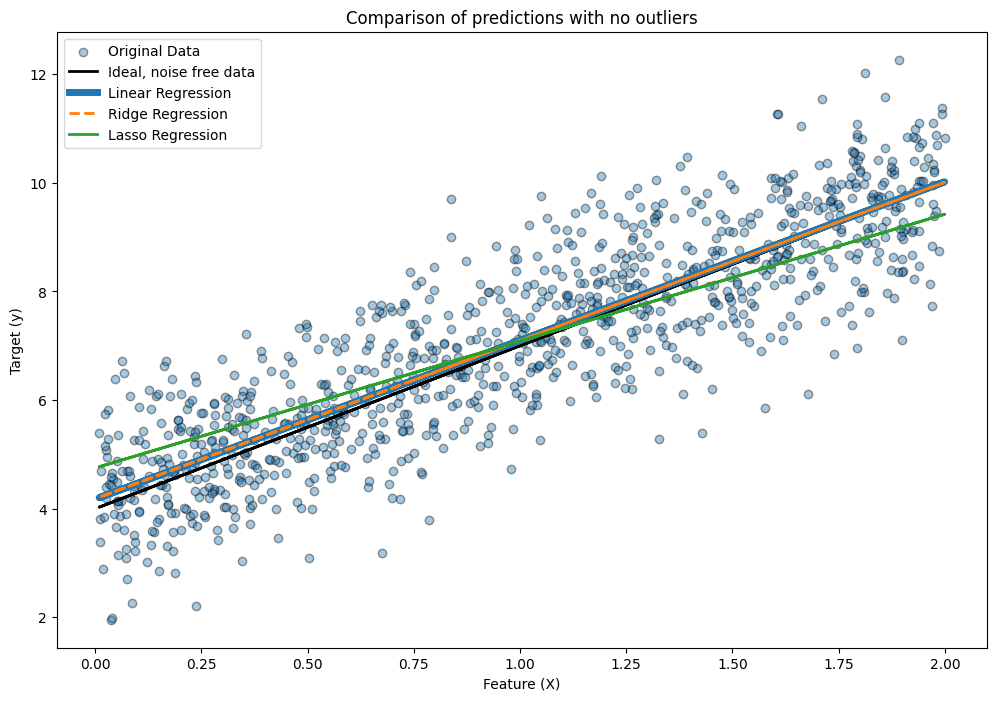

In [10]:
# Fit a simple linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_pred_lin = lin_reg.predict(X)

# Fit a ridge regression model (regularization to control large coefficients)
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(X, y)
y_pred_ridge = ridge_reg.predict(X)

# Fit a lasso regression model (regularization to control large coefficients)
lasso_reg = Lasso(alpha=.2)
lasso_reg.fit(X, y)
y_pred_lasso = lasso_reg.predict(X)

# Print the regression results
regression_results(y, y_pred_lin, 'Ordinary')
regression_results(y, y_pred_ridge, 'Ridge')
regression_results(y, y_pred_lasso, 'Lasso')


# Plot the data and the predictions
plt.figure(figsize=(12, 8))

# # Scatter plot of the original data
plt.scatter(X, y, alpha=0.4, ec='k', label='Original Data')

# Plot the ideal regression line (noise free data)
plt.plot(X, y_ideal,  linewidth=2, color='k',label='Ideal, noise free data')

# Plot predictions from the simple linear regression model
plt.plot(X, y_pred_lin,  linewidth=5, label='Linear Regression')

# Plot predictions from the ridge regression model
plt.plot(X, y_pred_ridge, linestyle='--',linewidth=2, label='Ridge Regression')

# Plot predictions from the lasso regression model
plt.plot(X, y_pred_lasso,  linewidth=2, label='Lasso Regression')

plt.xlabel('Feature (X)')
plt.ylabel('Target (y)')

plt.title('Comparison of predictions with no outliers')
plt.legend()
plt.show()

<details><summary>Click here for the solution</summary>
    
```python
   
# Fit a simple linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_pred_lin = lin_reg.predict(X)

# Fit a ridge regression model (regularization to control large coefficients)
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(X, y)
y_pred_ridge = ridge_reg.predict(X)

# Fit a lasso regression model (regularization to control large coefficients)
lasso_reg = Lasso(alpha=0.2)
lasso_reg.fit(X, y)
y_pred_lasso = lasso_reg.predict(X)

# Print the regression results
regression_results(y, y_pred_lin, 'Ordinary')
regression_results(y, y_pred_ridge, 'Ridge')
regression_results(y, y_pred_lasso, 'Lasso')


# Plot the data and the predictions
plt.figure(figsize=(12, 8))

# # Scatter plot of the original data
plt.scatter(X, y, alpha=0.4,ec='k', label='Original Data')

# Plot the ideal regression line (noise free data)
plt.plot(X, y_ideal,  linewidth=2, color='k',label='Ideal, noise free data')

# Plot predictions from the simple linear regression model
plt.plot(X, y_pred_lin,  linewidth=5, label='Linear Regression')

# Plot predictions from the ridge regression model
plt.plot(X, y_pred_ridge, linestyle='--',linewidth=2, label='Ridge Regression')

# Plot predictions from the lasso regression model
plt.plot(X, y_pred_lasso,  linewidth=2, label='Lasso Regression')

plt.xlabel('Feature (X)')
plt.ylabel('Target (y)')
# plt.ylim((0,20))
plt.title('Comparison of predictions with no outliers')
plt.legend()
plt.show()
```


## Multiple regression regularization and Lasso feature selction
Now that you have explored regularization for simple, one-dimensional regression, let's take a deeper look at a multiple regression modelling scenario.
You'll again compare performances of the three inear regression methods and then use the Lasso result to select important features to use in another modelling pass.


### Create a high dimensional synthetic dataset with a small number of informative features using `make_regression`

The output of `make_regression` is generated by applying a random linear regression model based on `n_informative` nonzero regressors and some adjustable gaussian noise.
Along with the features and the target vairable, the regression model coefficients can also be obtained from the output.

We'll split the data into training and testing sets, and also split the ideal predictions, which is a line based on the linear regression model.


In [11]:
from sklearn.datasets import make_regression

X, y, ideal_coef = make_regression(n_samples=100, n_features=100, n_informative=10, noise=10, random_state=42, coef=True)

# Get the ideal predictions based on the informative coefficients used in the regression model
ideal_predictions = X @ ideal_coef

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, ideal_train, ideal_test = train_test_split(X, y, ideal_predictions, test_size=0.3, random_state=42)


### ✅ What does this code do?

1. **`make_regression(...)`**:
   This function generates a synthetic linear regression dataset:

   * `n_samples=100`: 100 data points
   * `n_features=100`: each data point has 100 features (like columns)
   * `n_informative=10`: only 10 of those 100 features actually affect the target `y`
   * `noise=10`: adds some randomness (noise) to simulate real-world data
   * `coef=True`: returns the **true coefficients** (`ideal_coef`) used to generate `y`

2. **Variables returned**:

   * `X`: 100×100 feature matrix
   * `y`: target values (with noise)
   * `ideal_coef`: the true coefficients (100 numbers, mostly zeros except 10)

---

### 🧠 What does `@` do?

In Python, the **`@` operator** is used for **matrix multiplication**.

So, this line:

```python
ideal_predictions = X @ ideal_coef
```

means:

> Multiply the matrix `X` (shape: 100×100) with the vector `ideal_coef` (length 100) to get a new vector of predicted values (length 100).

This gives you the **ideal target values** (without noise), purely based on the true relationship between features and target — like:

$$
\hat{y} = X \cdot \text{ideal\_coef}
$$

---

### 🧪 Example:

Imagine a small version:

```python
X = [[1, 2],
     [3, 4]]

ideal_coef = [5, 6]

# Matrix multiplication
# Row 1: (1*5 + 2*6) = 5 + 12 = 17
# Row 2: (3*5 + 4*6) = 15 + 24 = 39

X @ ideal_coef = [17, 39]
```

So `@` just does what you'd expect in regular math when multiplying a matrix by a vector.

---

### ✅ Summary:

* `@` is used for **matrix multiplication** (like dot product).
* In `X @ ideal_coef`, it calculates the **predicted target values** using the **true coefficients**.
* This helps compare how well a regression model performs vs the ideal scenario.


### Initialize and fit the linear regression models and use them to predict the target.


In [12]:
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=1.0)
linear = LinearRegression()

# Fit the models
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
linear.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

### Print the regression results


In [13]:
regression_results(y_test, y_pred_linear, 'Ordinary')
regression_results(y_test, y_pred_ridge, 'Ridge')
regression_results(y_test, y_pred_lasso, 'Lasso')

Evaluation metrics for Ordinary Linear Regression
explained_variance:  0.4354
r2:  0.4018
MAE:  77.7353
MSE:  9844.2714
RMSE:  99.2183

Evaluation metrics for Ridge Linear Regression
explained_variance:  0.4446
r2:  0.4079
MAE:  76.9622
MSE:  9744.4693
RMSE:  98.7141

Evaluation metrics for Lasso Linear Regression
explained_variance:  0.9815
r2:  0.9815
MAE:  13.8855
MSE:  304.644
RMSE:  17.4541



### Exercise 3. Do you have some immediate thoughts on these performance metrics?


In [ ]:
#### Enter your thoughts here (you can convert the cell to markdown)


<details><summary>Click here for the solution</summary>
    
The results for ordinary and ridge regession are poor. 

Explained variances are under 50%, and R^2 is very low.

However, ther result for Lasso is stellar.


### Plot the predictions vs actuals 
Let's get some more insight into the perfomance of these models.


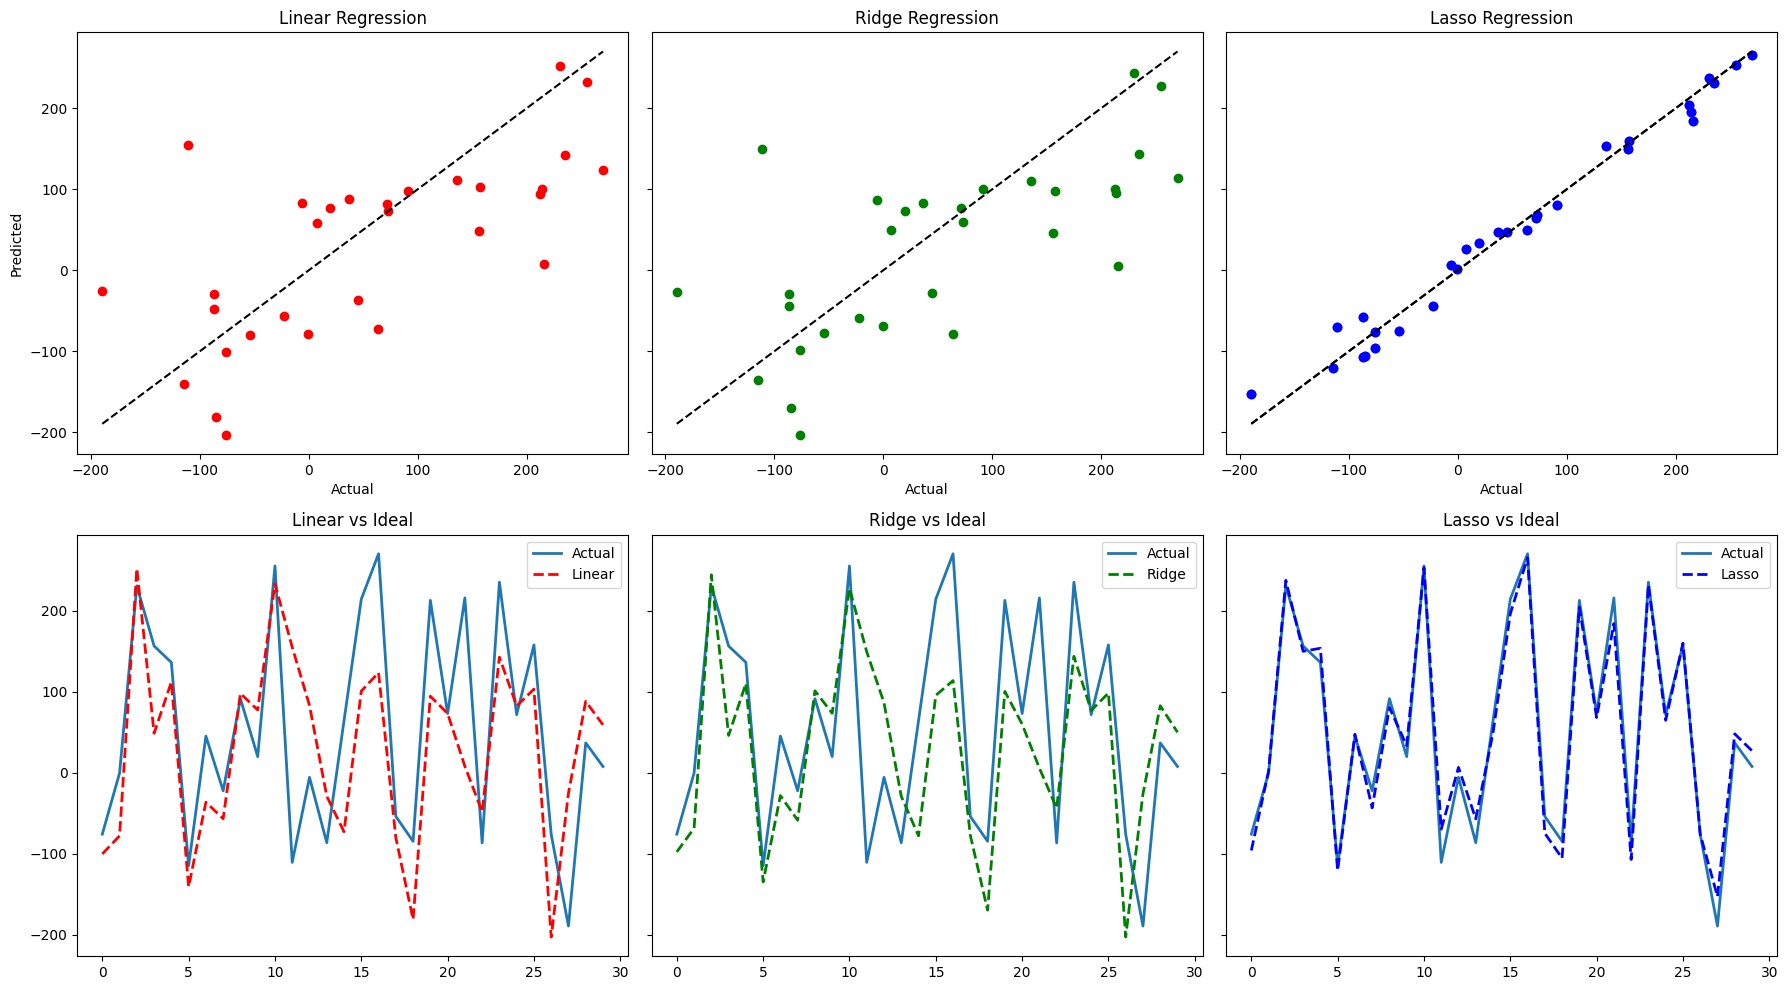

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

axes[0,0].scatter(y_test, y_pred_linear, color="red", label="Linear")
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[0,0].set_title("Linear Regression")
axes[0,0].set_xlabel("Actual",)
axes[0,0].set_ylabel("Predicted",)

axes[0,2].scatter(y_test, y_pred_lasso, color="blue", label="Lasso")
axes[0,2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[0,2].set_title("Lasso Regression",)
axes[0,2].set_xlabel("Actual",)

axes[0,1].scatter(y_test, y_pred_ridge, color="green", label="Ridge")
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[0,1].set_title("Ridge Regression",)
axes[0,1].set_xlabel("Actual",)

axes[0,2].scatter(y_test, y_pred_lasso, color="blue", label="Lasso")
axes[0,2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[0,2].set_title("Lasso Regression",)
axes[0,2].set_xlabel("Actual",)


# Line plots for predictions compared to actual and ideal predictions
axes[1,0].plot(y_test, label="Actual", lw=2)
axes[1,0].plot(y_pred_linear, '--', lw=2, color='red', label="Linear")
axes[1,0].set_title("Linear vs Ideal",)
axes[1,0].legend()
 
axes[1,1].plot(y_test, label="Actual", lw=2)
# axes[1,1].plot(ideal_test, '--', label="Ideal", lw=2, color="purple")
axes[1,1].plot(y_pred_ridge, '--', lw=2, color='green', label="Ridge")
axes[1,1].set_title("Ridge vs Ideal",)
axes[1,1].legend()
 
axes[1,2].plot(y_test, label="Actual", lw=2)
axes[1,2].plot(y_pred_lasso, '--', lw=2, color='blue', label="Lasso")
axes[1,2].set_title("Lasso vs Ideal",)
axes[1,2].legend()
 
plt.tight_layout()
plt.show()

 You can see visually how much more the predictions deviate from the ideal target values for the ordinary and ridge regression results than for the Lasso result.


### Model coefficients
Let's take a look at the coefficients for each model fit


In [ ]:
# Model coefficients
linear_coeff = linear.coef_
ridge_coeff = ridge.coef_
lasso_coeff = lasso.coef_


# Plot the coefficients
x_axis = np.arange(len(linear_coeff))
x_labels = np.arange(min(x_axis),max(x_axis),10)
plt.figure(figsize=(12, 6))

plt.scatter(x_axis, ideal_coef,  label='Ideal', color='blue', ec='k', alpha=0.4)
plt.bar(x_axis - 0.25, linear_coeff, width=0.25, label='Linear Regression', color='blue')
plt.bar(x_axis, ridge_coeff, width=0.25, label='Ridge Regression', color='green')
plt.bar(x_axis + 0.25, lasso_coeff, width=0.25, label='Lasso Regression', color='red')

plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Comparison of Model Coefficients')
plt.xticks(x_labels)
plt.legend()
plt.show()


# Plot the coefficient residuals
x_axis = np.arange(len(linear_coeff))

plt.figure(figsize=(12, 6))

plt.bar(x_axis - 0.25, ideal_coef - linear_coeff, width=0.25, label='Linear Regression', color='blue')
plt.bar(x_axis, ideal_coef - ridge_coeff, width=0.25, label='Ridge Regression', color='green')
# plt.bar(x_axis + 0.25, ideal_coef - lasso_coeff, width=0.25, label='Lasso Regression', color='red')
plt.plot(x_axis, ideal_coef - lasso_coeff, label='Lasso Regression', color='red')

plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Comparison of Model Coefficient Residuals')
plt.xticks(x_labels)
plt.legend()
plt.show()

You can see from the first plot how much closer the Lasso coefficients are to the ideal coefficients than for the other two models.
An easier way to visualize the difference is to look at the residual errors, as in the second plot. Clearly the Lasso coefficient residuals are much closer to zero than the others.


### Use Lasso to select the most important features and compare the three different linear regression models again on the resulting data.


#### Part 1. Choose a threshold value to select features based on the Lasso model coefficients
Use the coefficient residual plot to select a reasonable threshold value, beyond which the Lasso coefficients are significant.
To find a good threshold you can visually inspect the residuals plot and choose a value that distinguishes coefficients with larger than normal residuals.

Create a dataframe to compare the Lasso coefficients with the ideal coefficients, for the features selected with the Lasso coefficent threshold.

Include a boolean column that indicates whether the feature was selected as being important by the Lasso coefficent thresholding.

Display two filtered versions of the resulting dataframe:

1. Only those features identified as important by Lasso

2. Only the nonzero ideal coefficient indices

How did we do?


In [ ]:
threshold = 5 # selected by inspection of residuals plot

# Create a dataframe containing the Lasso model and ideal coefficients
feature_importance_df = pd.DataFrame({
    'Lasso Coefficient': lasso_coeff,
    'Ideal Coefficient': ideal_coef
})

# Mark the selected features
feature_importance_df['Feature Selected'] = feature_importance_df['Lasso Coefficient'].abs() > threshold


print("Features Identified as Important by Lasso:")
display(feature_importance_df[feature_importance_df['Feature Selected']])

print("\nNonzero Ideal Coefficient Indices")
display(feature_importance_df[feature_importance_df['Ideal Coefficient']>0])



The result is very good. We managed to correctly identify 9 out of the 10 important features.
#### Part 2. Use the threshold to select the most important features for use in modelling.
Also split your data into train, test sets, including the ideal targets. How many features did you end up selecting?


In [ ]:
important_features = feature_importance_df[feature_importance_df['Feature Selected']].index

In [ ]:
# Filter features
X_filtered = X[:, important_features]
print("Shape of the filtered feature set:", X_filtered.shape)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, ideal_train, ideal_test = train_test_split(X_filtered, y, ideal_predictions, test_size=0.3, random_state=42)

#### Part 3. Fit and apply the three models to the selected features


In [ ]:
# Initialize the models
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=1.0)
linear = LinearRegression()

# Fit the models
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
linear.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

### Exercise 4. Print the regression performance results


In [ ]:
# Enter your code here:
regression_results(y_test, ..., 'Ordinary')
regression_results(y_test, ..., 'Ridge')
regression_results(y_test, ..., 'Lasso')

<details><summary>Click here for the solution</summary>


```python
regression_results(y_test, y_pred_linear, 'Ordinary')
regression_results(y_test, y_pred_ridge, 'Ridge')
regression_results(y_test, y_pred_lasso, 'Lasso')



```


### Let's compare the results to see the effect of feature selection using Lasso

Here are the previous results:

Evaluation metrics for Ordinary Linear Regression
| Metric | Score |
|:---|:---|
|explained_variance: |0.4346 |
|r2   |0.4012 |
|MAE  | 77.7479 |
|MSE  | 9855.428 |
|RMSE   |99.2745 |

Evaluation metrics for Ridge Linear Regression
| Metric | score |
|:---|:---|
|explained_variance: | 0.4446|
|r2  |0.4079|
|MAE | 76.9622|
|MSE  |9744.4693|
|RMSE  |98.7141|

Evaluation metrics for Lasso Linear Regression
| Metric | score |
|:---|:---|
|explained_variance: | 0.9815|
|r2  |0.9815|
|MAE | 13.8855|
|MSE  |304.644|
|RMSE | 17.4541|

The new results are vastly improved for ordinary and Ridge regression, and slightly improved for Lasso, supporting the idea that **Lasso regression can be very beneficial when used as a feature selector.**


### Exercise 5. Regenerate the same plots as before and compare the results


In [ ]:
# Enter your code here
# Plot the predictions vs actuals


<details><summary>Click here for the solution</summary>


```python

# Plot the predictions vs actuals 
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

axes[0,0].scatter(y_test, y_pred_linear, color="red", label="Linear")
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[0,0].set_title("Linear Regression",)
axes[0,0].set_xlabel("Actual",)

axes[0,2].scatter(y_test, y_pred_lasso, color="blue", label="Lasso")
axes[0,2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[0,2].set_title("Lasso Regression",)
axes[0,2].set_xlabel("Actual",)
axes[0,2].set_ylabel("Predicted",)

axes[0,1].scatter(y_test, y_pred_ridge, color="green", label="Ridge")
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[0,1].set_title("Ridge Regression",)
axes[0,1].set_xlabel("Actual",)

axes[0,2].scatter(y_test, y_pred_lasso, color="blue", label="Lasso")
axes[0,2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[0,2].set_title("Lasso Regression",)
axes[0,2].set_xlabel("Actual",)
axes[0,2].set_ylabel("Predicted",)

# Line plots for predictions compared to actual and ideal predictions
axes[1,0].plot(y_test, label="Actual", lw=2)
axes[1,0].plot(y_pred_linear, '--', lw=2, color='red', label="Linear")
axes[1,0].set_title("Linear vs Ideal",)
axes[1,0].legend()
 
axes[1,1].plot(y_test, label="Actual", lw=2)
axes[1,1].plot(y_pred_ridge, '--', lw=2, color='green', label="Ridge")
axes[1,1].set_title("Ridge vs Ideal",)
axes[1,1].legend()
 
axes[1,2].plot(y_test, label="Actual", lw=2)
axes[1,2].plot(y_pred_lasso, '--', lw=2, color='blue', label="Lasso")
axes[1,2].set_title("Lasso vs Ideal",)
axes[1,2].legend()

plt.tight_layout()
plt.show()


```

<details><summary>Click here for comparison</summary>
As you can see, with the assistance of Lasso feature selection, all three models have performed extremely well! 


### Congratulations! You're ready to move on to your next lesson!
 
 
## Author
<a href="https://www.linkedin.com/in/jpgrossman/" target="_blank">Jeff Grossman</a>


### Other Contributors
<a href="https://www.linkedin.com/in/abhishek-gagneja-23051987/" target="_blank">Abhishek Gagneja</a>

<!-- 
## Changelog

| Date | Version | Changed by | Change Description |
|:------------|:------|:------------------|:---------------------------------------|
| 2024-11-05 | 1.0  | Jeff Grossman    | Create content |
 -->


## <h3 align="center"> © IBM Corporation. All rights reserved. <h3/>
